# Clustering

### Due to the fact that we decided to use a subset of the data for this preliminary analysis, we will use the original dataframe without the rows that are not correct and we will correct them for the future analysis.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import pickle
with open('scaler.pickle', 'rb') as f:
    scaler: StandardScaler = pickle.load(f)

# Read in the data
final_clean = pd.read_csv('../dataset/data/final_clean.csv')
#show the number of rows and columns
final_clean.shape


(51267, 31)

### We are left with a fraction of the original data, but it is still enough to work with, at least for this first part. 


# -----------------------------------------------------------------------------------------------------------------------------

# K-MEANS CLUSTERING

### But to be used with Clustering algorithm like K-means, we need to have numerical values, so we will drop the categorical columns and we will use the numerical ones.
### Then we will also remove the outliers, by simply removing the rows that have a value that is below the 25th percentile or above the 75th percentile.

In [2]:
no_outliers = final_clean.copy()
numeric_cols = no_outliers.select_dtypes(include=['float64', 'int64']).columns

for col in numeric_cols:
    q1 = no_outliers[col].quantile(0.25)
    q3 = no_outliers[col].quantile(0.75)
    iqr = q3 - q1
    fence_low  = q1 - 1.5 * iqr
    fence_high = q3 + 1.5 * iqr
    no_outliers = no_outliers[(no_outliers[col] >= fence_low) * (no_outliers[col] <= fence_high)]

### We can now use the K-means algorithm to cluster the data. We will use the elbow method to find the optimal number of clusters.

  0%|          | 0/8 [00:00<?, ?it/s]/home/simone/Unipi/InProgress/DM/DataMining-2023/.env/lib/python3.11/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.11 is maybe too old for this OS.
  warnings.warn(
100%|██████████| 8/8 [02:24<00:00, 18.07s/it]


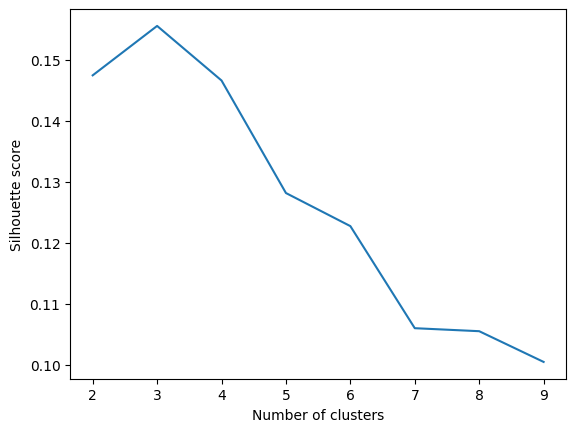

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm
sample = final_clean.sample(frac=0.5).copy()
numeric_cols = final_clean.select_dtypes(include=['float64', 'int64']).columns
# numeric_cols = ['latitude', 'longitude', 'min_age_participants', 'avg_age_participants', 'max_age_participants',  'n_participants', 'timestamp', 'povertyPercentage', 'p_males', 'p_females', 'p_participants_child', 'p_participants_teen', 'p_participants_adult', 'p_killed', 'p_injured', 'p_arrested', 'p_unharmed', 'month_cd_change_min_age_participants', 'month_cd_change_avg_age_participants', 'month_cd_change_max_age_participants', 'month_cd_ratio_males', 'month_cd_ratio_females', 'month_cd_ratio_participants_child', 'month_cd_ratio_participants_teen', 'month_cd_ratio_participants_adult', 'month_cd_ratio_killed', 'month_cd_ratio_injured', 'month_cd_ratio_arrested', 'month_cd_ratio_unharmed', 'month_cd_incidents', 'month_cd_votes_incidents', 'cd_population', 'percentage_republican', 'percentage_democrat', 'cd_month_SHOT_INJURED', 'cd_month_SHOT_DEAD', 'cd_month_NON_SHOOTING', 'cd_month_SHOTS_FIRED_UNHARMED', 'cd_month_OTHER']

# to_drop = ['date_year', 'date_month', 'state', 'congressional_district', 'incident_characteristics1', 'date_day', 'city_or_county', 'n_participants_child', 'n_participants_teen', 'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured', 'n_arrested', 'n_unharmed', 'party', 'candidatevotes', 'totalvotes', 'state_population']
numeric = sample[numeric_cols]
k_min = 2
k_max = 10
# Sample
# Standardize
# scaler = MinMaxScaler()
# numeric_scaled = scaler.fit_transform(numeric)
# numeric_scaled = np.log(numeric_scaled + 1)
numeric_scaled = numeric
# PCA
pca = PCA(n_components=2)
numeric_pca = pca.fit_transform(numeric_scaled)
# KMeans
scores = []
for k in tqdm(range(k_min, k_max)):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=42).fit(numeric_scaled)
    score = silhouette_score(numeric_scaled, kmeans.labels_)
    scores.append(score)
plt.plot(range(k_min, k_max), scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

### As we can see from the graph, the optimal number of clusters is 3, because it's the highest point of the curve.
### We will use 3 as the number of clusters for the K-means algorithm, and we will use PCA to reduce the dimensionality of the data to 2, so we can plot the clusters.


/home/simone/Unipi/InProgress/DM/DataMining-2023/.env/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


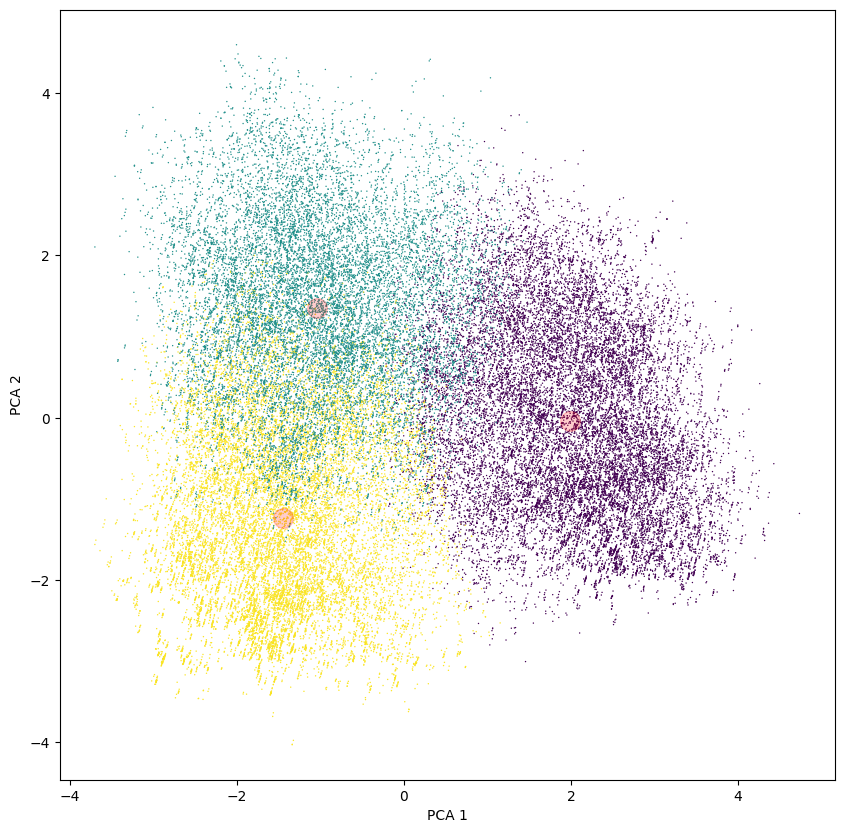

In [25]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

numeric_cols = final_clean.select_dtypes(include=['float64', 'int64']).columns
numeric_scaled = final_clean[numeric_cols]

# PCA
pca = PCA(n_components=2)
numeric_pca = pca.fit_transform(numeric_scaled)

# KMeans
scores = []
k = 3
kmeans = KMeans(n_clusters=k, random_state=0, n_init=42).fit(numeric_scaled)

centroids_pca = pca.transform(kmeans.cluster_centers_)

# Plot
plt.figure(figsize=(10, 10))
plt.scatter(numeric_pca[:, 0], numeric_pca[:, 1], c=kmeans.labels_, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], c='red', s=200, alpha=0.2)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()



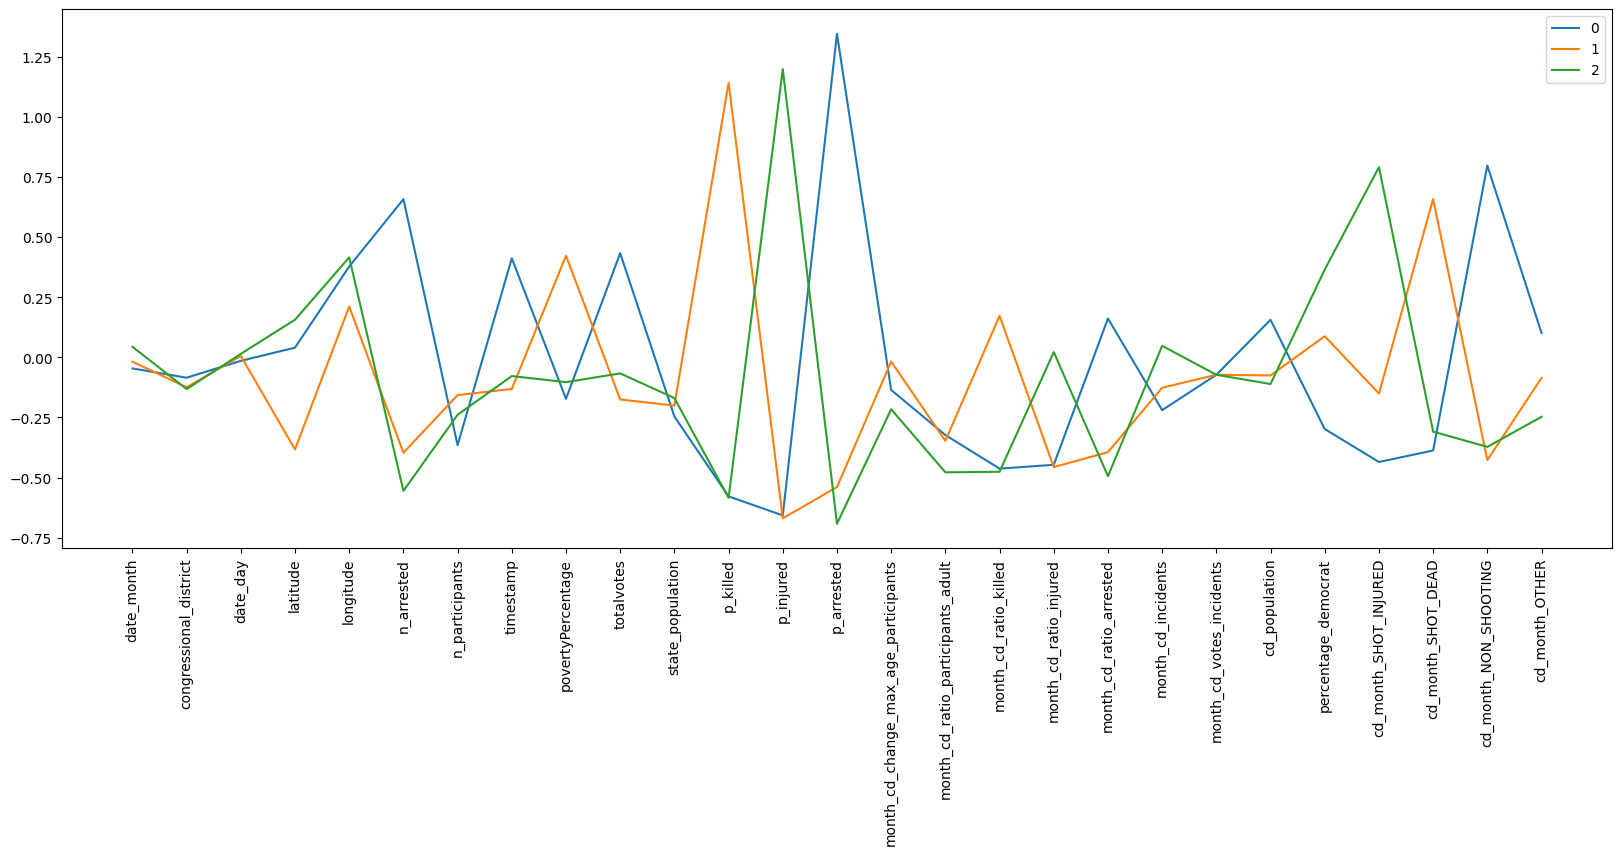

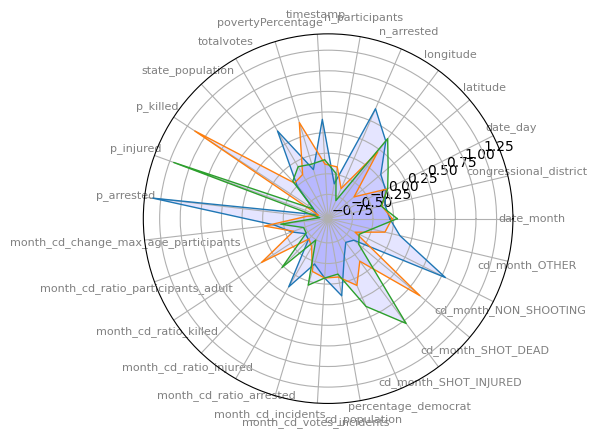

In [11]:
#Let's visualize the centroids of each cluster in the original feature space with two plots: a line plot and a radar plot.
plt.figure(figsize=(20, 7))
tran = kmeans.cluster_centers_
plt.plot(tran.T)
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation='vertical')
plt.legend(range(k))
plt.show()

from math import pi
 
# number of variable
N = len(numeric_scaled.columns)
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
for i in range(0, len(kmeans.cluster_centers_)):
    angles = [n / float(N) * 2 * pi for n in range(N)]
    values = kmeans.cluster_centers_[i].tolist()
    values += values[:1]
    angles += angles[:1]
# Initialise the radar plot
    ax = plt.subplot(polar=True)
# Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], numeric_scaled.columns, color='grey', size=8) 
# Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid')
 # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)

### The following graphs will show the values of each attribute for each cluster

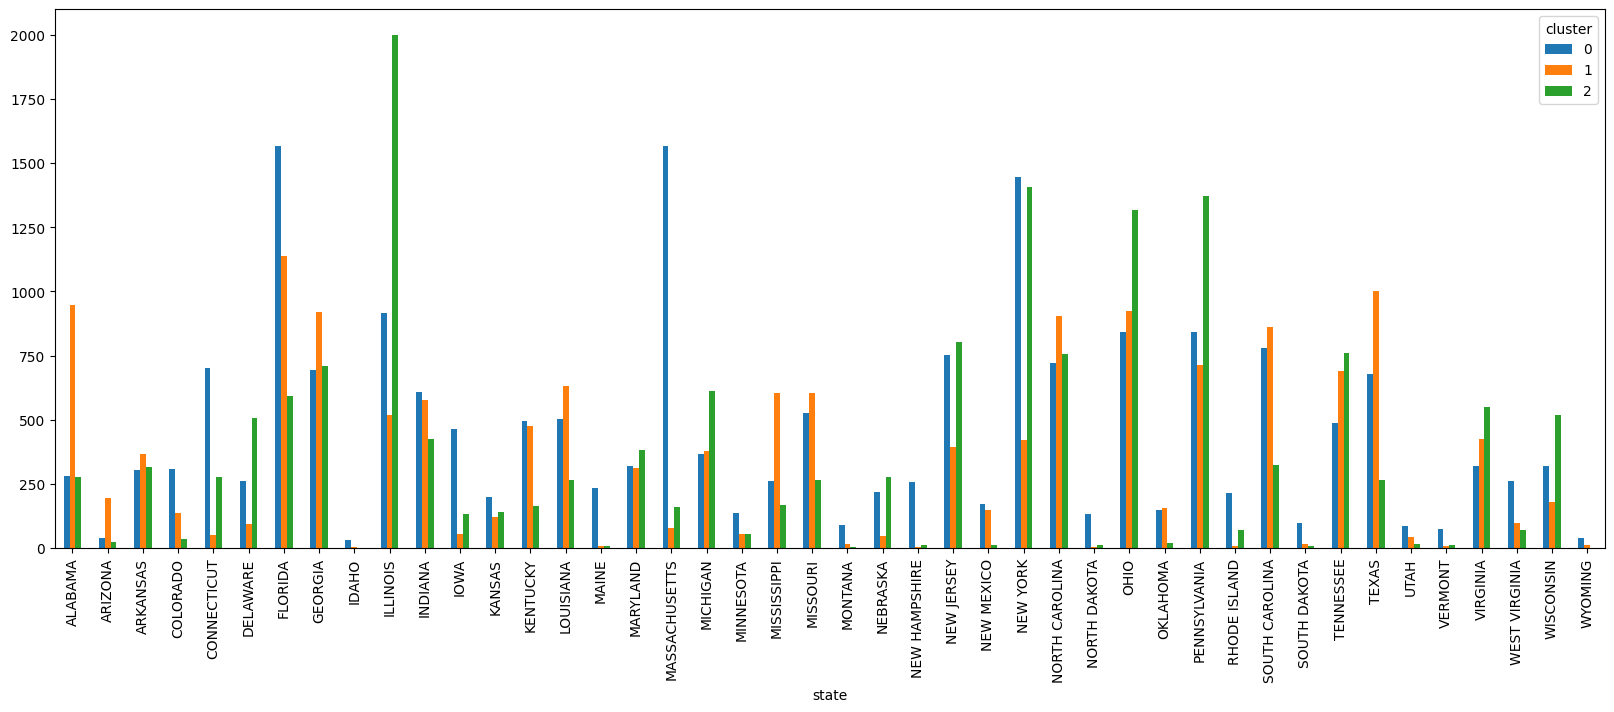

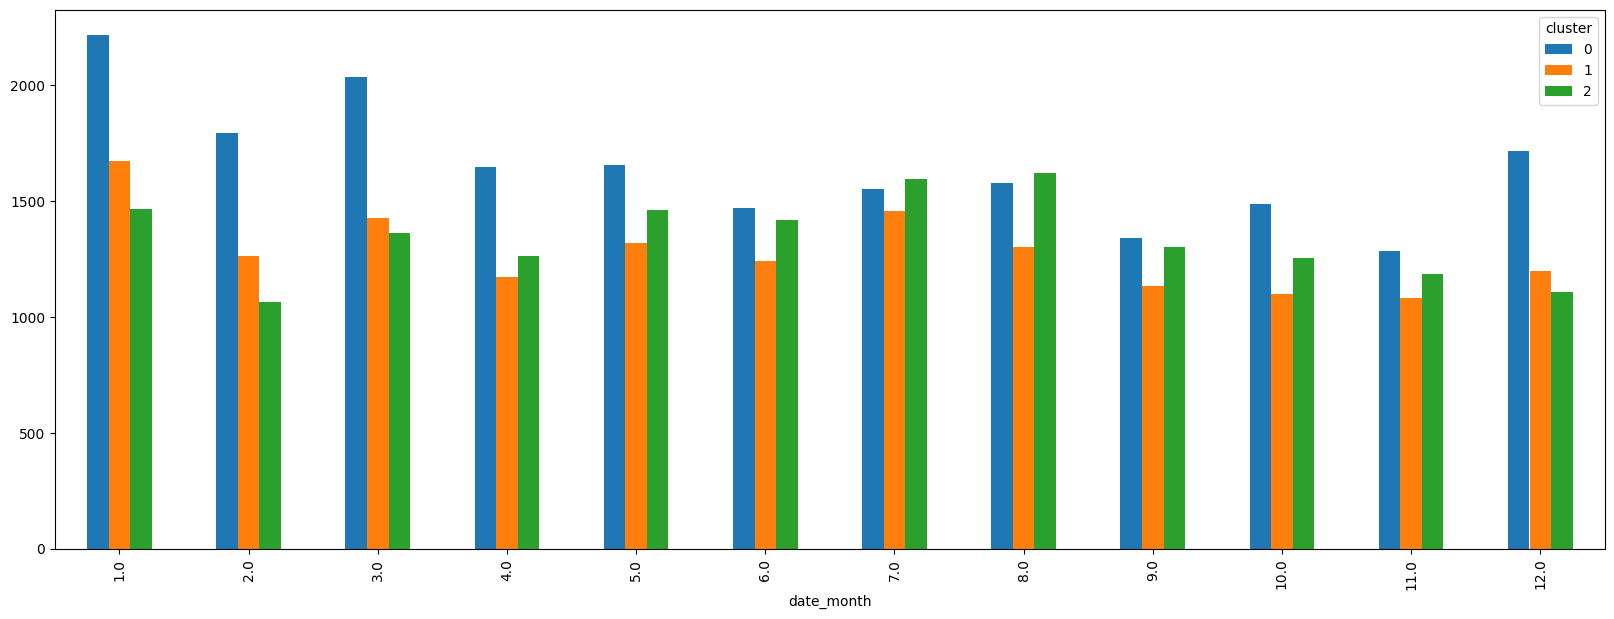

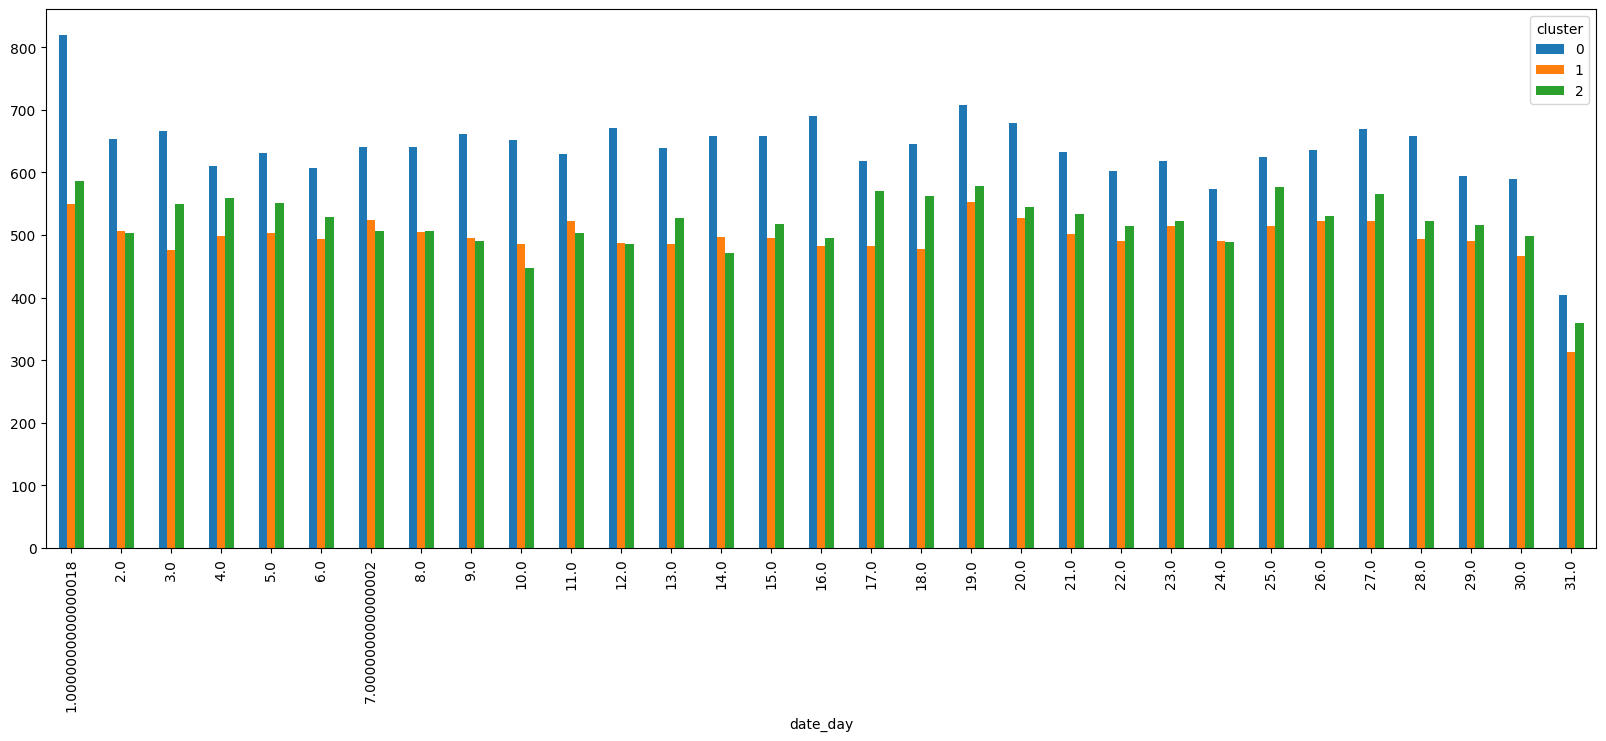

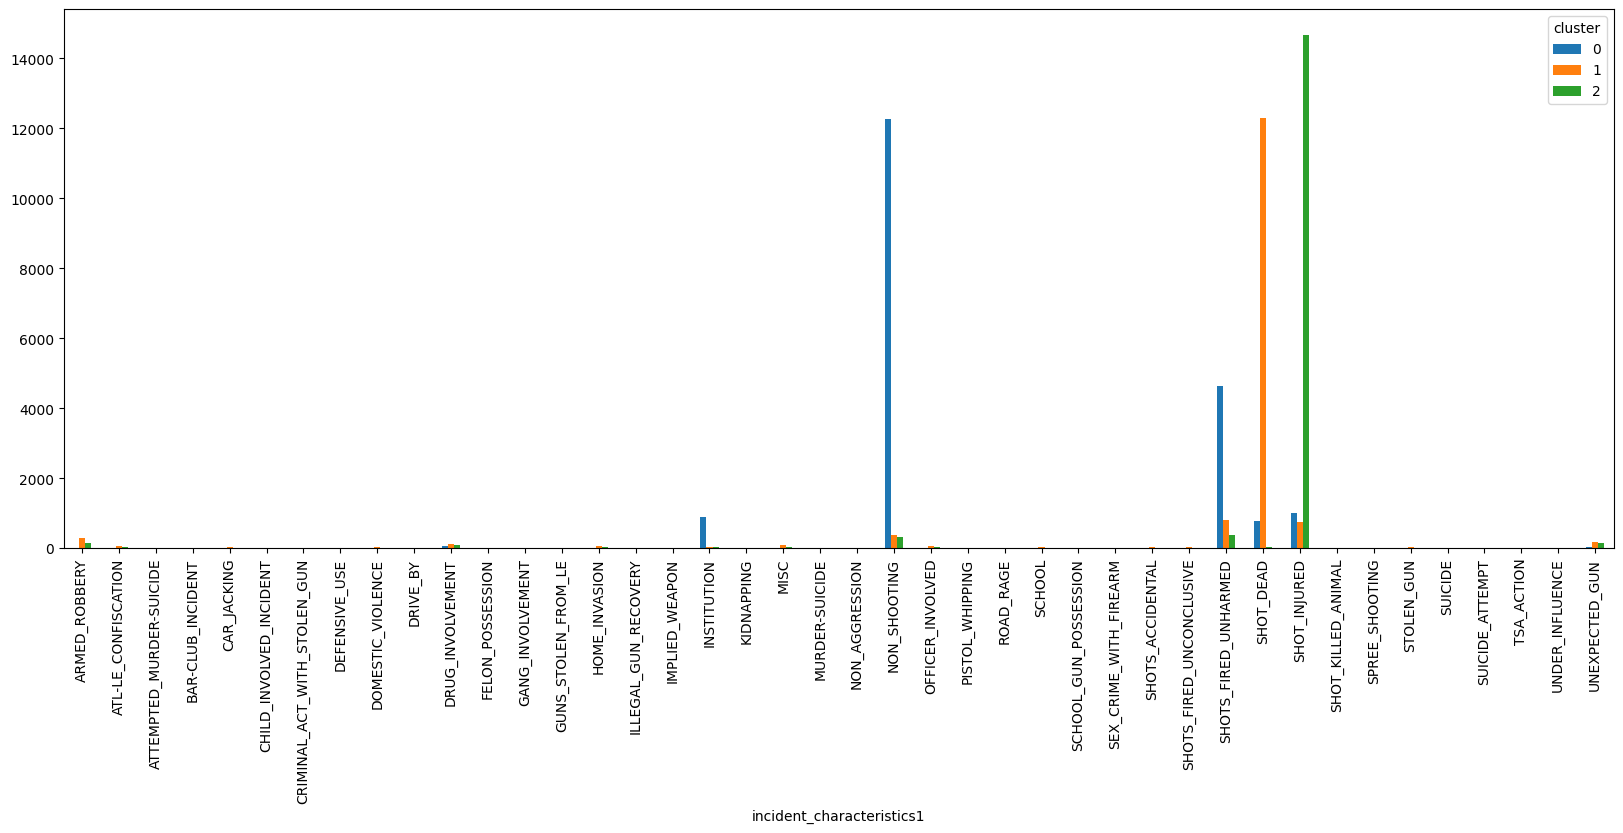

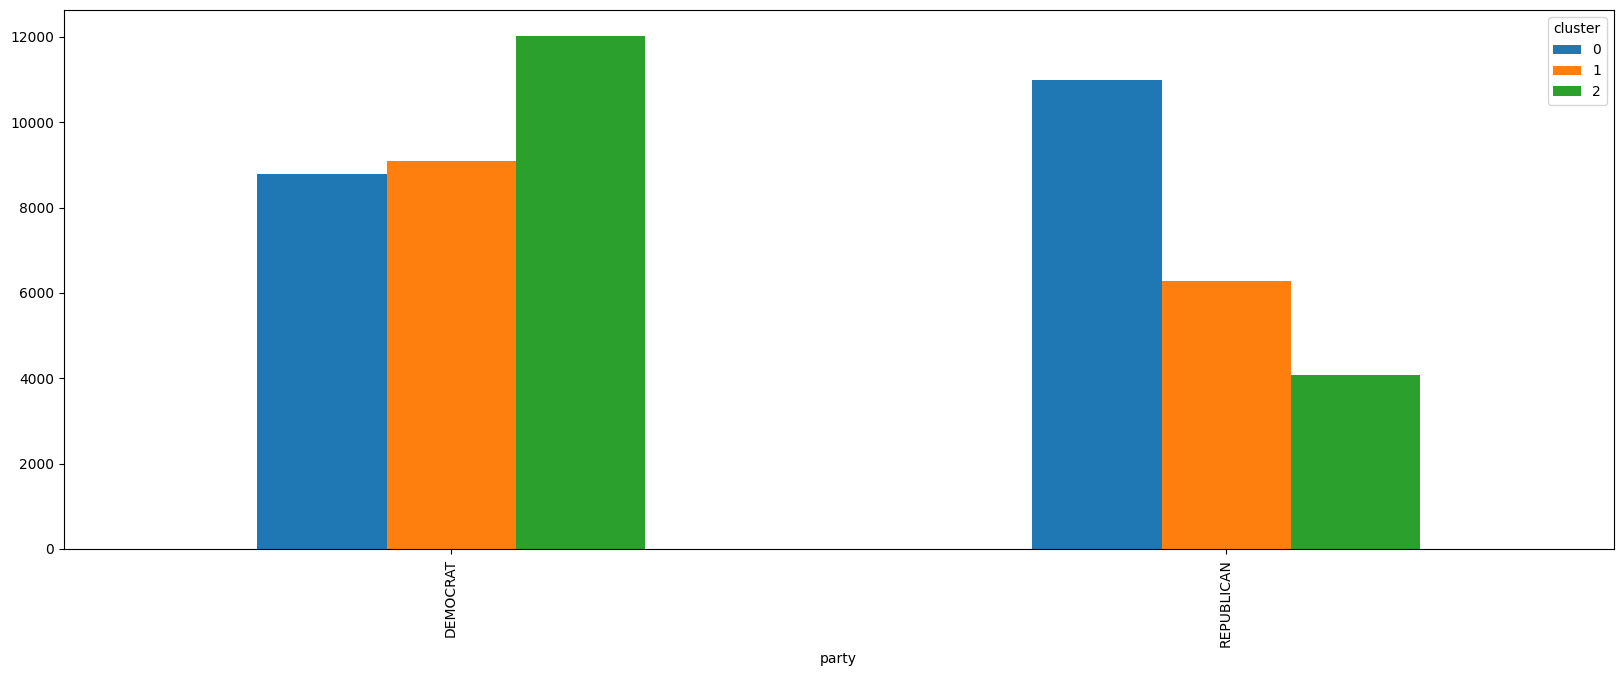

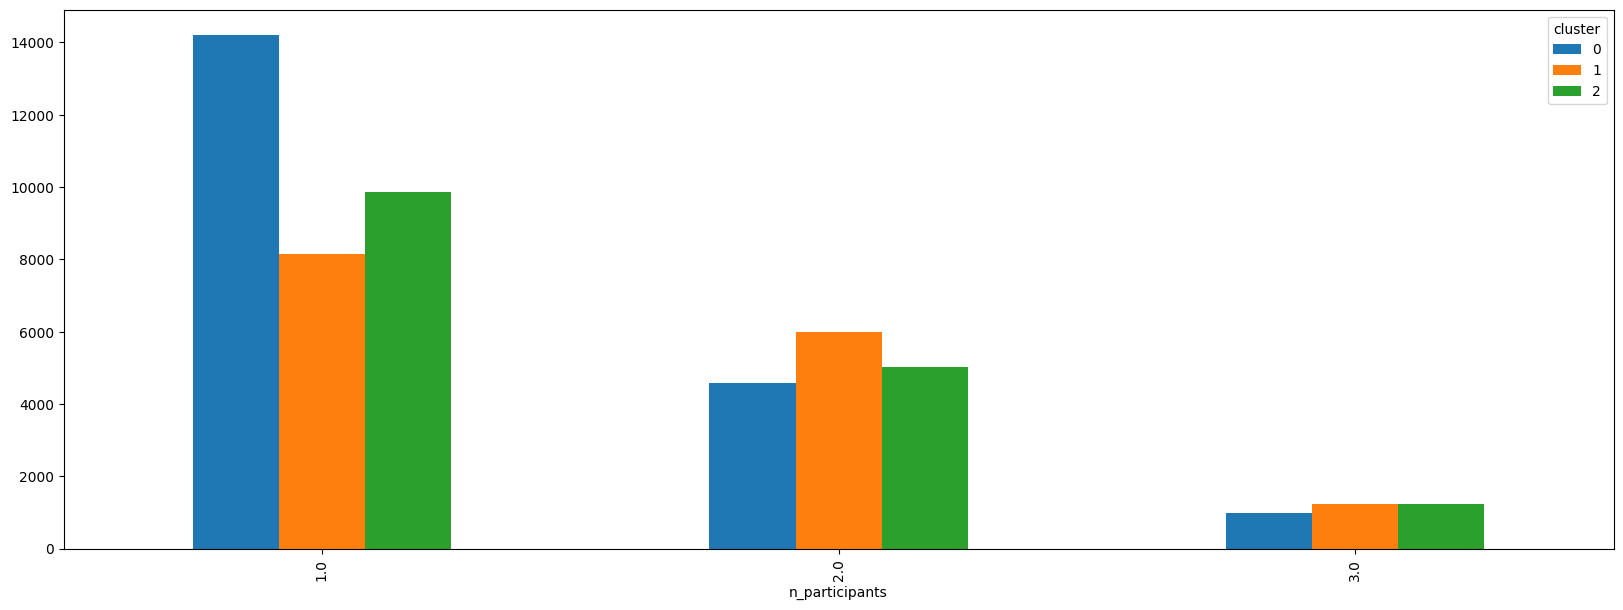

In [20]:


w_clusters = final_clean.copy()
n_w_clusters = w_clusters.select_dtypes(include=['float64', 'int64'])
n_w_clusters_vals = scaler.inverse_transform(n_w_clusters)
n_w_clusters = pd.DataFrame(n_w_clusters_vals, columns=n_w_clusters.columns)
w_clusters[n_w_clusters.columns] = n_w_clusters
w_clusters['cluster'] = kmeans.labels_
w_clusters = w_clusters.sort_values(by=['cluster'])

o = w_clusters.select_dtypes(include=['float64', 'int64']).columns

cats = ['state', 'date_month', 'date_day', 'incident_characteristics1', 'party', 'n_participants']
for cat in cats:
    xt = pd.crosstab(w_clusters[cat], w_clusters['cluster'])
    xt['total'] = xt.sum(axis=1)
    del xt['total']
    xt = xt.sort_index()
    xt.plot.bar(stacked=False, figsize=(20, 7))
    plt.show();

/tmp/ipykernel_93222/4033849112.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_scaled['cluster'] = kmeans.labels_


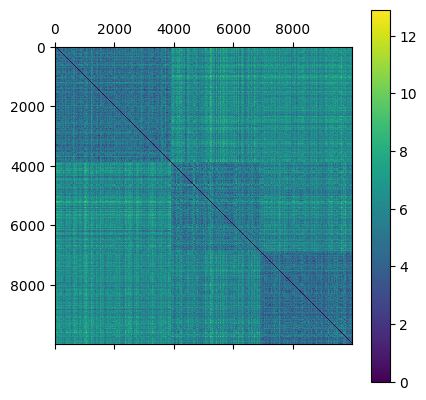

In [31]:
from scipy.spatial.distance import pdist, squareform
import numpy as np

numeric_scaled['cluster'] = kmeans.labels_

sample = numeric_scaled.sample(n=10000).copy()

sample = sample.sort_values(by=['cluster'])

# Calculate the Euclidean distance matrix
euclidean_distances = pdist(sample, metric='euclidean')

# reshape the distances into a square matrix
euclidean_distances = squareform(euclidean_distances)

plt.matshow(euclidean_distances)
plt.colorbar()
plt.show()

# -----------------------------------------------------------------------------------------------------------------------------

# D-BSCAN CLUSTERING

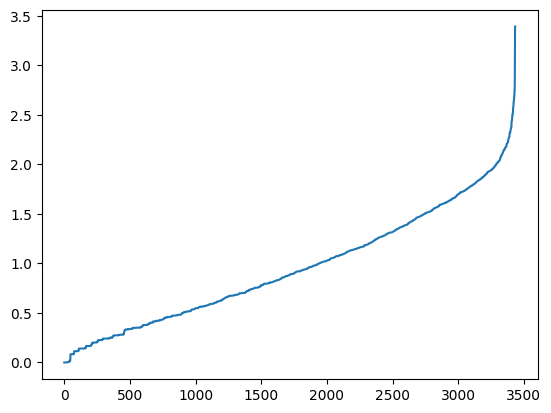

In [38]:
# DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

db_scaled = final_clean.copy()
per_state = db_scaled[db_scaled['state'] == 'ILLINOIS']
numeric_cols = per_state.select_dtypes(include=['float64', 'int64']).columns

numeric_db = per_state[numeric_cols]

# NN
nn = NearestNeighbors(n_neighbors=2*numeric_db.shape[1])
nn.fit(numeric_db)
distances, indices = nn.kneighbors(numeric_db)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.show()


[-1  0  1  2  3]
(3435,)
(3435, 28)


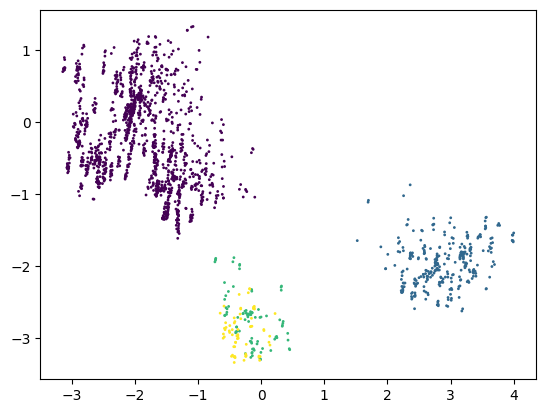

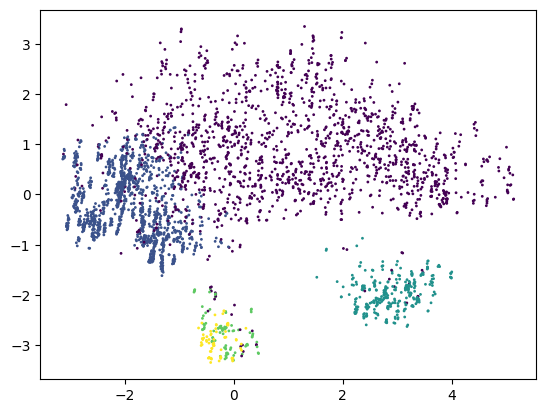

In [51]:
# DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#we use the epsilon value of 2. and the minimum number of samples of 2 times the number of dimensions
dbs = DBSCAN(eps=2., min_samples=2*numeric_db.shape[1])
dbs.fit(numeric_db)
labels = dbs.labels_
print(np.unique(labels))
print(labels.shape)
print(numeric_db.shape)

# UMAP
pca = PCA(n_components=2)
numeric_pca = pca.fit_transform(numeric_db)

filtered_data = numeric_pca[labels != -1]
filtered_labels = labels[labels != -1]

plt.scatter(filtered_data[:, 0], filtered_data[:, 1], s=1, c=filtered_labels)
plt.show()


plt.scatter(numeric_pca[:, 0], numeric_pca[:, 1], s=1, c=labels)
plt.show()

# Add cluster labels to w_clusters
per_state.loc[per_state['state'] == 'ILLINOIS', 'cluster'] = labels

/tmp/ipykernel_61997/1670137055.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_db['cluster'] = labels


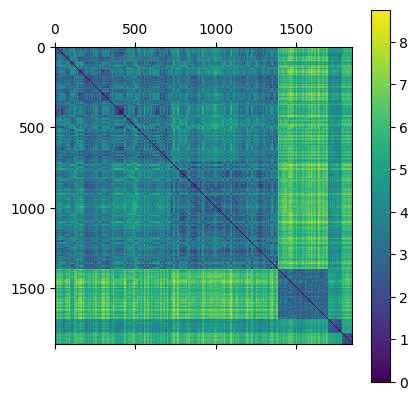

In [52]:
from scipy.spatial.distance import pdist, squareform
import numpy as np

numeric_db['cluster'] = labels

sample = numeric_db.copy()
sample = sample[labels != -1]

sample = sample.sort_values(by=['cluster'])

# Calculate the Euclidean distance matrix
euclidean_distances = pdist(sample, metric='euclidean')

# reshape the distances into a square matrix
euclidean_distances = squareform(euclidean_distances)

plt.matshow(euclidean_distances)
plt.colorbar()
plt.show()

         date_month  congressional_district  date_day  latitude  longitude  \
cluster                                                                      
0.0        0.073213                0.121671 -0.111507  0.003739  -0.000247   
1.0        0.188846                0.139097  0.011997 -0.103904   0.002681   
2.0        0.158590               -0.166638  0.007709 -0.030223  -0.004948   
3.0       -0.235163               -0.034144  0.066507 -0.006363  -0.000131   

         n_arrested  n_participants  timestamp  povertyPercentage  totalvotes  \
cluster                                                                         
0.0        0.000000        0.216688  -0.063587           0.051711    0.206895   
1.0        0.049088        0.043207  -0.087663           0.040784    0.050176   
2.0        0.000000        0.054535   0.064748          -0.027592   -0.112010   
3.0        0.000000        0.000000  -0.112909           0.047965    0.074672   

         ...  month_cd_ratio_injured  month_

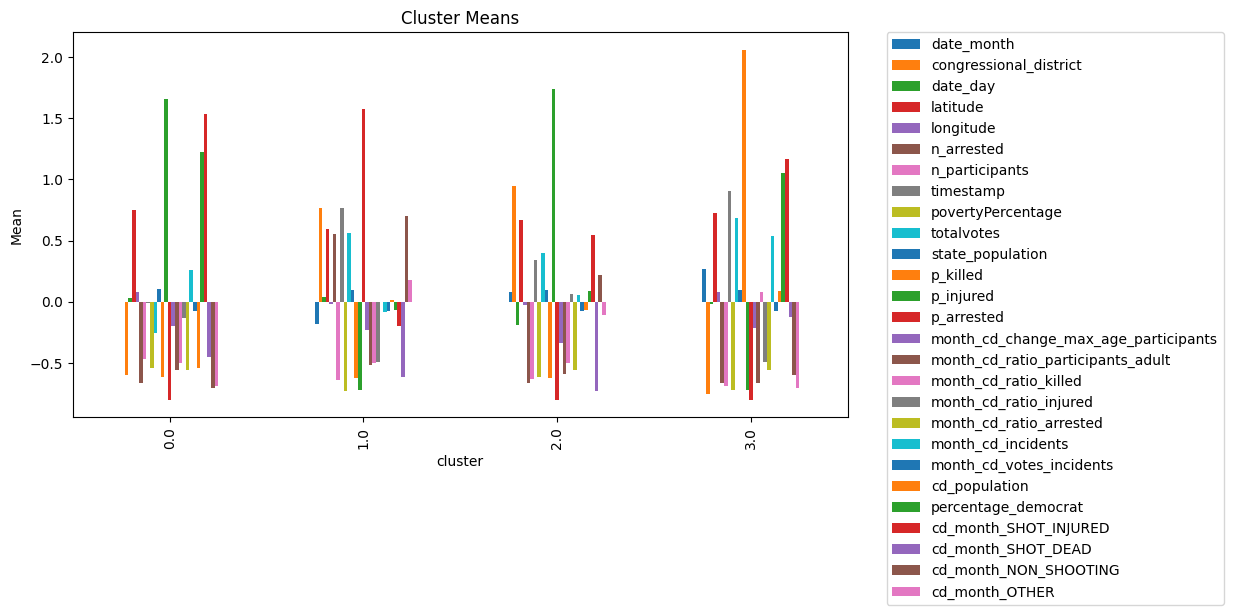

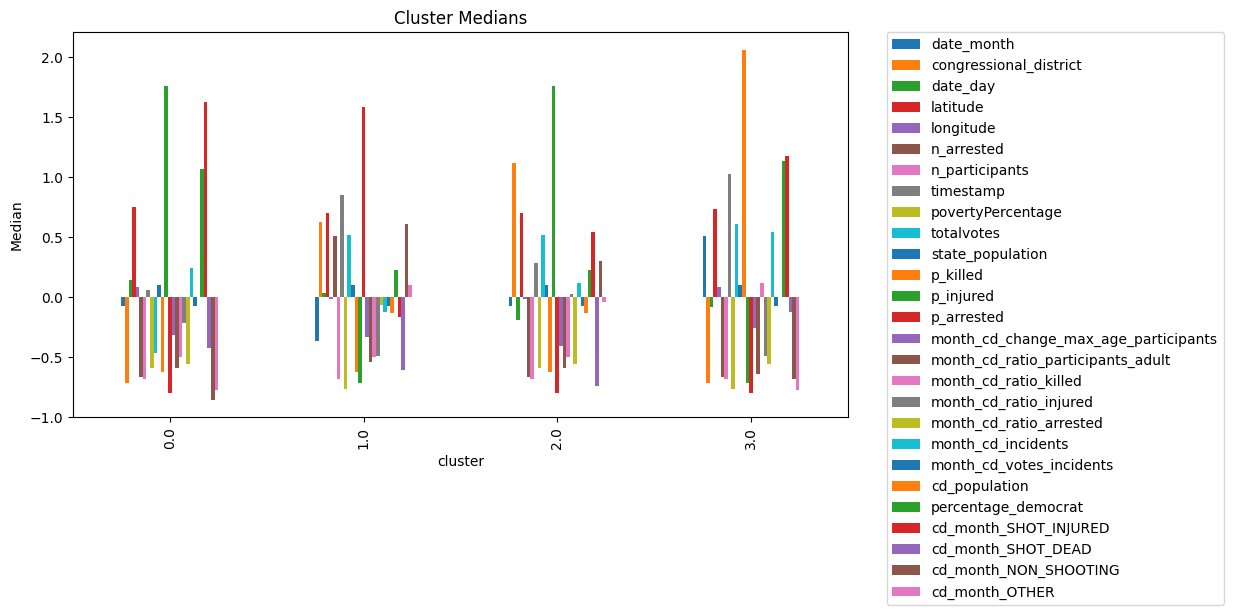

In [54]:
per_state_num = per_state.select_dtypes(include=['float64', 'int64'])
per_state_num = per_state_num[per_state_num['cluster'] != -1]
cluster_means = per_state_num.groupby('cluster').mean()
cluster_medians = per_state_num.groupby('cluster').median()
# 
# Calculate the difference between clusters
cluster_diff = cluster_means - cluster_medians
# 
# Display the difference between clusters
print(cluster_diff)

import matplotlib.pyplot as plt

# Plotting the cluster means
plt.figure(figsize=(10, 5))
plt.title('Cluster Means')
plt.xlabel('Features')
plt.ylabel('Mean')
cluster_means.plot(kind='bar', ax=plt.gca())
plt.xticks(rotation='vertical')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

# move legend outside of the plot


# Plotting the cluster medians
plt.figure(figsize=(10, 5))
plt.title('Cluster Medians')
plt.xlabel('Features')
plt.ylabel('Median')
cluster_medians.plot(kind='bar', ax=plt.gca())
plt.xticks(rotation='vertical')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()



## Hierarchical clustering

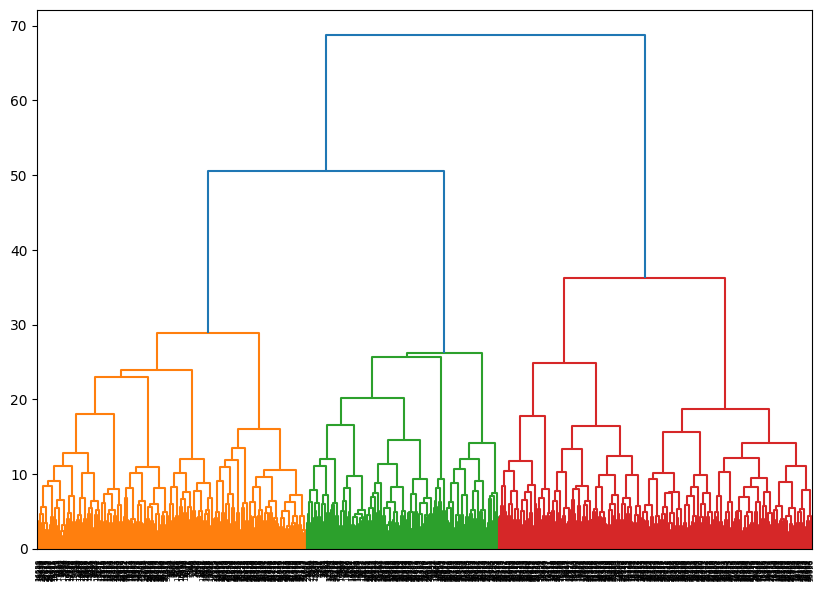

In [19]:
num_hierr = final_clean.copy()
num_hierr = num_hierr.select_dtypes(include=['float64', 'int64'])
num_hierr = num_hierr.sample(n=1000, random_state=0)

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

linked = linkage(num_hierr, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linked,
           orientation='top',
           labels=num_hierr.index,
           distance_sort='descending',
           show_leaf_counts=True)
plt.show()





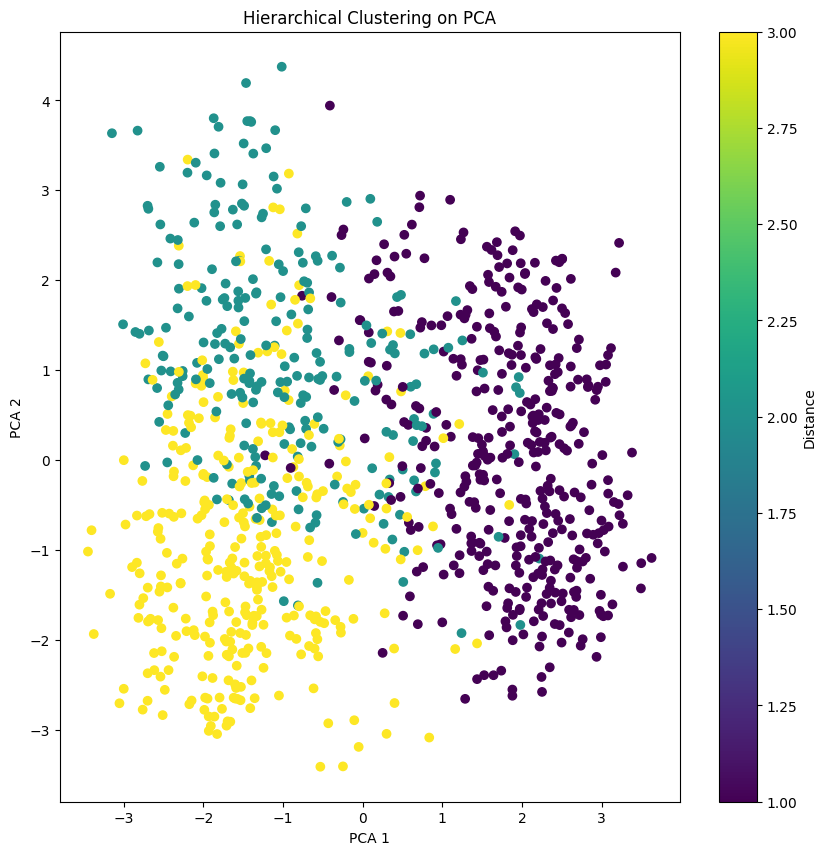

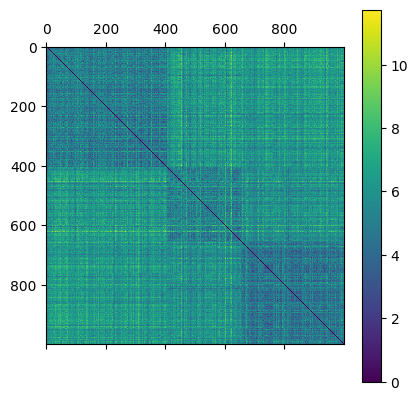

In [20]:


clusters = fcluster(linked, 3, criterion='maxclust')

# Perform PCA
pca = PCA(n_components=2)
num_hierr_pca = pca.fit_transform(num_hierr)

# Plot the result on PCA
plt.figure(figsize=(10, 10))
plt.scatter(num_hierr_pca[:, 0], num_hierr_pca[:, 1], c=clusters, cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Hierarchical Clustering on PCA')
plt.colorbar(label='Distance')
plt.show()

from scipy.spatial.distance import pdist, squareform
import numpy as np

num_hierr['cluster'] = clusters

sample = num_hierr.copy()

sample = sample.sort_values(by=['cluster'])

# Calculate the Euclidean distance matrix
euclidean_distances = pdist(sample, metric='euclidean')

# reshape the distances into a square matrix
euclidean_distances = squareform(euclidean_distances)

plt.matshow(euclidean_distances)
plt.colorbar()
plt.show()

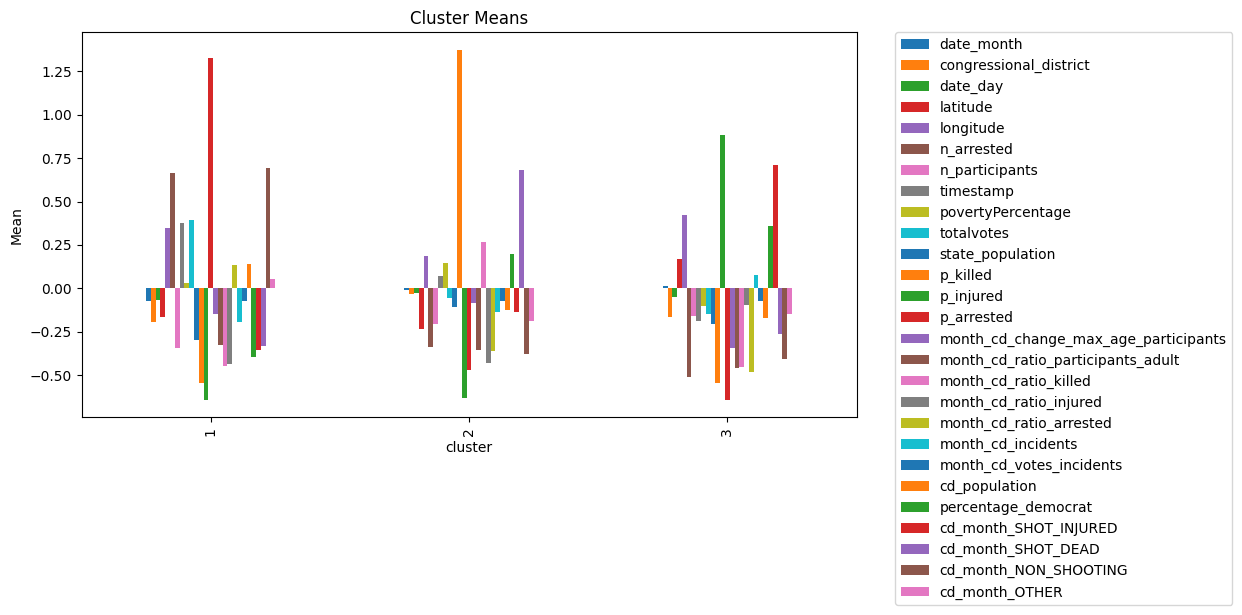

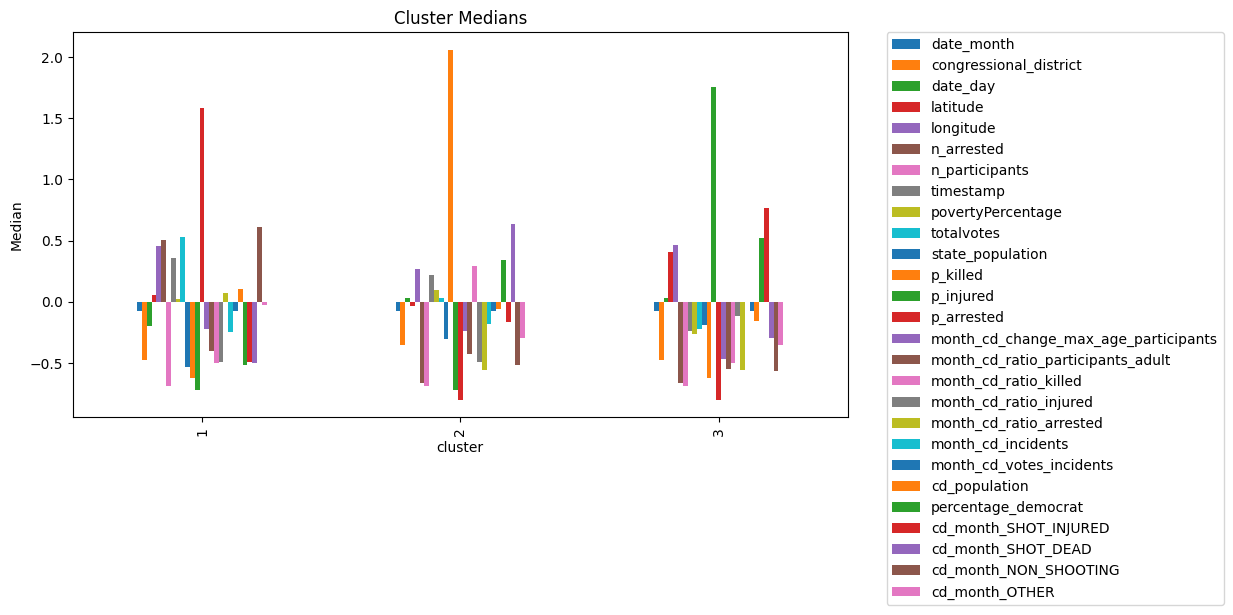

In [32]:
cluster_means = num_hierr.groupby('cluster').mean()
cluster_medians = num_hierr.groupby('cluster').median()
# 
# Calculate the difference between clusters
cluster_diff = cluster_means - cluster_medians
# 

import matplotlib.pyplot as plt

# Plotting the cluster means
plt.figure(figsize=(10, 5))
plt.title('Cluster Means')
plt.xlabel('Features')
plt.ylabel('Mean')
cluster_means.plot(kind='bar', ax=plt.gca())
plt.xticks(rotation='vertical')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

# move legend outside of the plot


# Plotting the cluster medians
plt.figure(figsize=(10, 5))
plt.title('Cluster Medians')
plt.xlabel('Features')
plt.ylabel('Median')
cluster_medians.plot(kind='bar', ax=plt.gca())
plt.xticks(rotation='vertical')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

